In [725]:
#Import all the necessary dependencies
from google.colab import files
#uploaded = files.upload()
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


In [726]:
#Naming of respective Image types: Training and Testing, Positive and Negative
imageNamesPosTrain = ['crop_000010b.bmp', 'crop001008b.bmp', 'crop001028a.bmp', 'crop001030c.bmp', 'crop001045b.bmp', 'crop001047b.bmp', 'crop001063b.bmp', 'crop001275b.bmp', 'crop001672b.bmp', 'person_and_bike_026a.bmp']
imagesNameNegTrain = ['01-03e_cut.bmp', '00000053a_cut.bmp', '00000057a_cut.bmp', '00000062a_cut.bmp', '00000091a_cut.bmp', '00000093a_cut.bmp', 'no_person__no_bike_213_cut.bmp', 'no_person__no_bike_219_cut.bmp', 'no_person__no_bike_247_cut.bmp', 'no_person__no_bike_259_cut.bmp']

imageNamesPosTest = ['crop001034b.bmp', 'crop001070a.bmp', 'crop001278a.bmp', 'crop001500b.bmp', 'person_and_bike_151a.bmp']
imagesNameNegTest = ['00000003a_cut.bmp', '00000090a_cut.bmp', '00000118a_cut.bmp', 'no_person__no_bike_258_Cut.bmp', 'no_person__no_bike_264_cut.bmp']

In [727]:
#images to be converted to ASCII Txt format for their Feature vectors
images2Ascii = ['crop001028a.bmp', 'crop001030c.bmp', '00000091a_cut.bmp', 'crop001278a.bmp', 'crop001500b.bmp', '00000090a_cut.bmp']



In [728]:
#Function to convert Image to grayscale using given formula
def grayScale(img):
  
  #sepearate the three colour channels
  R,G,B = img[:,:,0], img[:,:,1] , img[:,:,2]
 
  #Using given formula
  imgG = 0.299 * R + 0.587 * G + 0.114 * B
  
  #rounding the values
  h,w = imgG.shape 
  for i in range(h):
    for j in range(w):
      imgG[i][j] =round(imgG[i][j])
  cv2_imshow(imgG)
  return imgG

In [729]:
#Function of Prewitts Filter to return Maginitude and Tan inverse Values
def prewitts(gaussian_smoothedImage):
  #Define Horizontal Magnitude Matrix
  Gx = gaussian_smoothedImage.copy()
  Kx = gaussian_smoothedImage.copy()

  #Prewitts Filter
  Mx = np.array([[-1,0,1], [-1,0,1], [-1,0,1]], np.float32)
  My = np.array([[1,1,1], [0,0,0], [-1,-1,-1]],np.float32)

  width, height = gaussian_smoothedImage.shape
  
  for i in range(width):
    for j in range(height):
      #If values are outside or at the edge, we ignore them  and set them to Zero  
      if (i <= 3) or (j <= 3) or (i >= width -4 ) or (j >=height-4):
        Gx[i][j] = 0 
      else:
        #create a block to apply the prewitts filter on
        block= Kx[i-1:i+2, j-1:j+2]
        mean = 0
        for k in range(3):
          for l in range(3):
            mean = mean + (block[k][l] * Mx[k][l])
        #Normalisation of the Image
        Gx[i][j] = mean/3
        

  #Similarly on Vertical Magnitude 
  Gy = gaussian_smoothedImage.copy()
  Ky = gaussian_smoothedImage.copy()

  for i in range(width):
    for j in range(height):
      if (i <= 3) or (j <= 4) or (i >= width -4) or (j >=height-4):
        Gy[i][j] = 0 
      else:
        block= Ky[i-1:i+2, j-1:j+2]
        mean = 0
        for k in range(3):
          for l in range(3):
            mean = mean + (block[k][l] * My[k][l])
        #division by 2 to normalise
        Gy[i][j] = mean/3
      
  #define Magnitude Vector and Tan inverse Values
  M = gaussian_smoothedImage.copy()
  tanValue = gaussian_smoothedImage.copy()

  for i in range(width):
    for j in range(height):  
      if (i <= 3) or (j <= 3) or (i >= width -4 ) or (j >=height-4):
        M[i][j] = 0 
        tanValue[i][j] = 0
      else:
       #using absolute values and division by 2 to normalise
        M[i][j] = math.sqrt((Gx[i][j]**2) + (Gy[i][j])**2)
        if Gy[i][j] == 0 or Gx[i][j] == 0:
          tanValue[i][j] = 0
          M[i][j] = 0
        else:
          #Defining Tan Inverse Values
          tanValue[i][j] = math.degrees(math.atan(Gy[i][j]/ Gx[i][j]))
          # Constraints for Tan Inverse Values
          if tanValue[i][j] < 0:
            tanValue[i][j] += 180

  cv2_imshow(M)
  return(M, tanValue)
  

In [730]:
#Function to return HOG Centers and HOG Bin Number, by using the given tan inverse value. 
#The function takes in the Tan Inverse Value and returns the appropriate Center and Bins where HOG value magnitude will be distributed
def hogCenter(value):
  if 10<value<=30:
    return 10,30, 1, 2

  elif 30<value<=50:
    return 30,50, 2, 3
  
  elif 50<value<=70:
    return 50,70, 3, 4
  
  elif 70<value<=90:
    return 70,90, 4, 5
  
  elif 90<value<=110:
    return 90,110, 5, 6
  
  elif 110<value<=130:
    return 110,130, 6, 7
  
  elif 130<value<=150:
    return 130,150, 7, 8
  
  elif 150<value<=170:
    return 150,170, 8, 9
  
  elif value >170 or value <= 10:
    return 170,10, 9, 1


In [731]:
#Returns the histogram 9 bin values for the cell input
def histogramFinder(magnitude, tanValues):
  height, width = magnitude.shape
  histogramBin = [0] * 9
  for i in range(height):
    for j in range(width):
      #call and find the HOG Centers and Bins where it will be distributed
      center1,center2, a1,a2 = hogCenter(tanValues[i][j])
      histogramBin[a1-1] = abs((tanValues[i][j] - center1)/20) * magnitude[i][j]
      histogramBin[a2-1] = abs((tanValues[i][j] - center2)/20) * magnitude[i][j]
  
  return histogramBin

In [732]:
#Function to find all Histograms for all cells and normalise the cells using L2 Block normalisations
def vectorGen(magnitude, tanValues):

  #Define all the parameters for shifting and tracing of image and formation of cells, all in pixel count
  height, width = magnitude.shape
  block_dim = 16
  cell_dim = 8
  blockCell = 2
  overlap = 8
  imageResX_block = height/block_dim
  imageResY_block = width/block_dim
  
  #Final Feature Vector for the image initialize
  a = []

  for i in range(4,height-4, cell_dim):
    for j in range(4, width-4, cell_dim):
      #Define a block from the Magnitude and Tan Inverse Values Matrix on which the operation has to be performed
      blockM= magnitude[i:i+block_dim,j:j+block_dim]
      blockT= tanValues[i:i+block_dim,j:j+block_dim]

      #One block has 4 cells, each defined from these values
      cell1M = blockM[0:8,0:8]
      cell2M = blockM[0:8,8:16]
      cell3M = blockM[8:16,0:8]
      cell4M = blockM[8:16,8:16]

      cell1T = blockT[0:8,0:8]
      cell2T = blockT[0:8,8:16]
      cell3T = blockT[8:16,0:8]
      cell4T = blockT[8:16,8:16]
      
      #Find Histogram for each cell
      a1 = histogramFinder(cell1M,cell1T)
      a2 = histogramFinder(cell2M,cell2T)
      a3 = histogramFinder(cell3M,cell3T)
      a4 = histogramFinder(cell4M,cell4T)
      sum = 0
      
      #L2 Block Normalisation by taking the sum of squares and square rooting them and dividing each Value
      for l in a1:
        sum = sum + l**2
      for l in a2:
        sum = sum + l**2
      for l in a3:
        sum = sum + l**2
      for l in a4:
        sum = sum + l**2
      
      normal = math.sqrt(sum)
      if normal == 0:
        normal = 1
      
      for l in range(len(a1)):
        a1[l] = a1[l]/normal

      for l in range(len(a2)):
        a2[l] = a2[l]/normal

      for l in range(len(a3)):
        a3[l] = a3[l]/normal

      for l in range(len(a4)):
        a4[l] = a4[l]/normal

      #Append the normalised values of each cell to form a feature vector of  7,524 values per image
      for o in a1:
        a.append(o)
      for o in a2:
        a.append(o)
      for o in a3:
        a.append(o)
      for o in a4:
        a.append(o)
  return(a)
  

In [733]:
#Final Function to generate feature Vector
def generateFeatureVector(img):
  grayscaleImage = grayScale(img)
  magnitude, tanValues = prewitts(grayscaleImage)
  final = vectorGen(magnitude, tanValues)
  print("Completed")
  return final
  

crop001028a.bmp


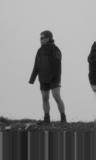

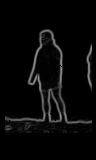

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

crop001030c.bmp


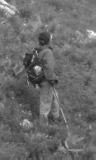

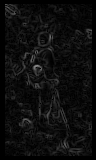

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

00000091a_cut.bmp


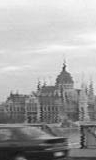

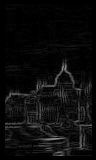

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

crop001278a.bmp


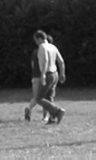

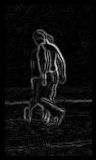

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

crop001500b.bmp


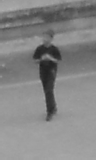

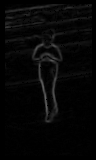

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

00000090a_cut.bmp


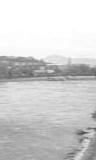

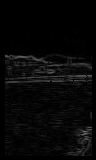

Completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [747]:
#Saving To Ascii files
import pandas as pd
def images2File():
  finalMatrix2File= []
  for i in images2Ascii:
    print(i)
    img = cv2.imread(i)
    temp = generateFeatureVector(img)
    temp2 = np.transpose(temp)
    df = pd.DataFrame(data=temp2)
    np.savetxt('Ascii'+i[:len(i)-4]+'.txt', df.values, fmt='%f', delimiter='\t')
    files.download('Ascii'+i[:len(i)-4]+'.txt')
images2File()


crop_000010b.bmp


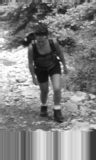

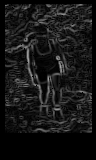

Completed
crop001008b.bmp


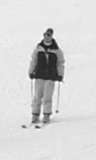

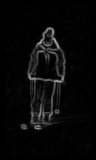

Completed
crop001028a.bmp


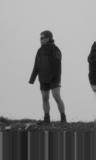

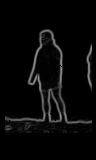

Completed
crop001030c.bmp


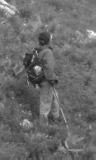

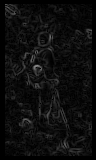

Completed
crop001045b.bmp


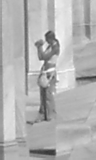

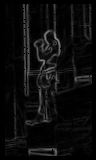

Completed
crop001047b.bmp


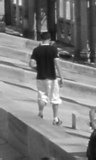

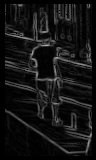

Completed
crop001063b.bmp


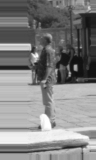

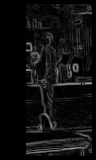

Completed
crop001275b.bmp


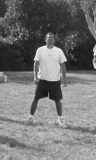

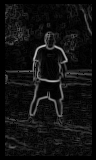

Completed
crop001672b.bmp


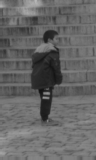

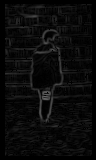

Completed
person_and_bike_026a.bmp


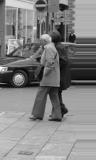

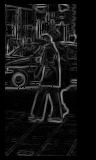

Completed
01-03e_cut.bmp


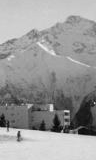

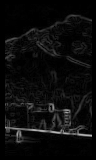

Completed
00000053a_cut.bmp


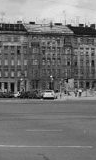

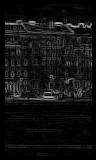

Completed
00000057a_cut.bmp


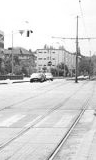

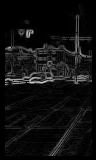

Completed
00000062a_cut.bmp


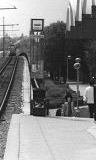

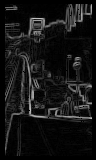

Completed
00000091a_cut.bmp


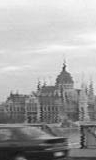

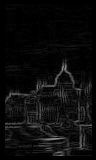

Completed
00000093a_cut.bmp


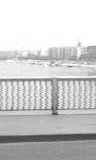

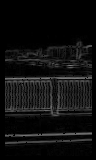

Completed
no_person__no_bike_213_cut.bmp


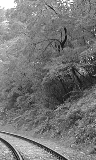

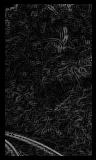

Completed
no_person__no_bike_219_cut.bmp


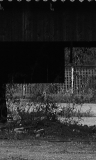

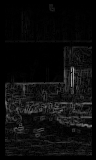

Completed
no_person__no_bike_247_cut.bmp


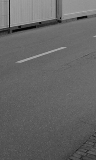

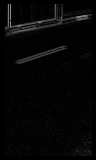

Completed
no_person__no_bike_259_cut.bmp


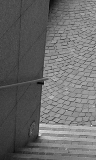

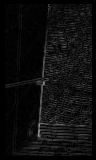

Completed


In [735]:
#Forming the final feature vector of the shape (7524, 20) with all the training image's HOG Values
finalMatrix = []

#Using the names of the images and training via a for Loop
for i in imageNamesPosTrain:
  print(i)
  img = cv2.imread(i)
  #Finding Training image's Feature Vector
  temp = generateFeatureVector(img)
  #Transposing the values to fit into columns
  temp2 = np.transpose(temp)
  #Appending the values to final feature vector
  finalMatrix.append(temp2)

#Similarly for Negative Training images
for i in imagesNameNegTrain:
  print(i)
  img = cv2.imread(i)
  temp = generateFeatureVector(img)
  temp2 = np.transpose(temp)
  finalMatrix.append(temp)



In [736]:
#Shape of Final Feature Vector of all training images 
finalTrainingFeatureVector = np.transpose(finalMatrix)
finalTrainingFeatureVector.shape

(7524, 20)

In [737]:
#Defining K-Nearest Neighbours Function for input test images based on feature vector
def knn(finalTrainingFeatureVector, finalTestingFeatureVector):
  height, width = finalTrainingFeatureVector.shape
  similarityArray = [0] * width
  #Define the similarity Matrix
  #Applying formula for similarity calculation for each image with each column of Feature Vector
  for i in range(width):
    denom = 0
    numer = 0
    for j in range(height):
      #denom += finalTestingFeatureVector[j]
      denom += finalTrainingFeatureVector[j][i]
      numer += min(finalTestingFeatureVector[j], finalTrainingFeatureVector[j][i])
    
    similarityArray[i] = numer/denom


  return(similarityArray)

00000003a_cut.bmp


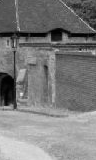

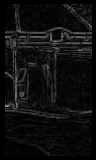

Completed
no_person__no_bike_213_cut.bmp
Distance:  0.36454079160953734
16
Classification:  NotHuman
no_person__no_bike_259_cut.bmp
Distance:  0.34740731446943013
19
Classification:  NotHuman
00000093a_cut.bmp
Distance:  0.34327878901452846
15
Classification:  NotHuman




00000090a_cut.bmp


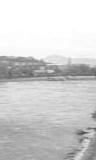

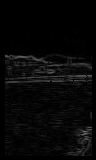

Completed
00000093a_cut.bmp
Distance:  0.3515547914407225
15
Classification:  NotHuman
00000057a_cut.bmp
Distance:  0.349688675338202
12
Classification:  NotHuman
no_person__no_bike_219_cut.bmp
Distance:  0.3418367522690121
17
Classification:  NotHuman




00000118a_cut.bmp


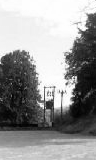

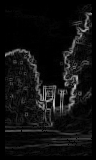

Completed
00000093a_cut.bmp
Distance:  0.34861628797335087
15
Classification:  NotHuman
00000053a_cut.bmp
Distance:  0.3467142068952738
11
Classification:  NotHuman
crop001275b.bmp
Distance:  0.3416817331199677
7
Classification:  Human




no_person__no_bike_258_Cut.bmp


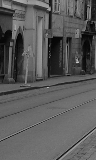

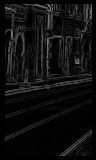

Completed
crop001672b.bmp
Distance:  0.3356173721313887
8
Classification:  Human
crop001030c.bmp
Distance:  0.3343610576356442
3
Classification:  Human
no_person__no_bike_247_cut.bmp
Distance:  0.32935830146651957
18
Classification:  NotHuman




no_person__no_bike_264_cut.bmp


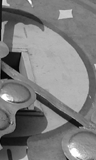

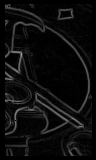

Completed
00000062a_cut.bmp
Distance:  0.3063033856525552
13
Classification:  NotHuman
crop_000010b.bmp
Distance:  0.30472653199774147
0
Classification:  Human
00000053a_cut.bmp
Distance:  0.29717537954816703
11
Classification:  NotHuman






In [738]:
#Running the operations on all the Test Images
for i in imagesNameNegTest:
  print(i)
  img = cv2.imread(i)
  #Finding the HOG Vector for the test image 
  temp = generateFeatureVector(img)
  #function run here for KNN
  similarityArray = knn(finalTrainingFeatureVector,temp)
  
  #Finding the similarity and top three Nearest Neighbours.
  n = 3
  similarityArray = np.array(similarityArray)

  indices = (-similarityArray).argsort()[:n]
  finalComp = imageNamesPosTrain + imagesNameNegTrain
  for k in indices:

    print(finalComp[k])
    print("Distance: ",similarityArray[k])
    print(k)
    if k>9:
      
      print("Classification: ",'NotHuman')
      
    else:
      print("Classification: ",'Human')
      
  print('\n')
  print('\n')




crop001034b.bmp


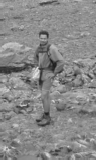

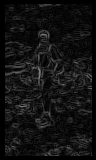

Completed
crop001030c.bmp
0.4032471555241049
Human
no_person__no_bike_213_cut.bmp
0.4024097531901664
NotHuman
crop_000010b.bmp
0.38456658881303785
Human




crop001070a.bmp


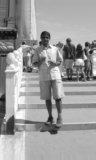

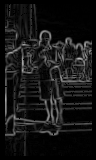

Completed
no_person__no_bike_213_cut.bmp
0.3405810469558638
NotHuman
crop001008b.bmp
0.3380507991045442
Human
00000091a_cut.bmp
0.32248712124904977
NotHuman




crop001278a.bmp


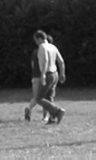

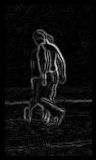

Completed
no_person__no_bike_213_cut.bmp
0.38493012862915427
NotHuman
crop001275b.bmp
0.37821233523190695
Human
crop001030c.bmp
0.37481977069374606
Human




crop001500b.bmp


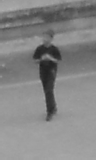

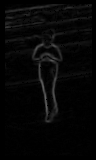

Completed
crop001008b.bmp
0.3916659591872465
Human
crop001672b.bmp
0.3896712084668554
Human
no_person__no_bike_259_cut.bmp
0.3805064278564557
NotHuman




person_and_bike_151a.bmp


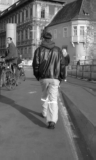

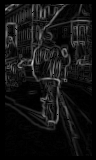

Completed
no_person__no_bike_213_cut.bmp
0.31904997171750604
NotHuman
crop001063b.bmp
0.3086610118760608
Human
00000057a_cut.bmp
0.30793667229890376
NotHuman






In [739]:

#Running the operations on all the Test Images
for i in imageNamesPosTest:
  print(i)
  img = cv2.imread(i)
  temp = generateFeatureVector(img)
  #function run here for KNN
  similarityArray = knn(finalTrainingFeatureVector,temp)
  #Finding the similarity and top three Nearest Neighbours.
  n = 3
  similarityArray = np.array(similarityArray)
  indices = (-similarityArray).argsort()[:n]
  finalComp = imageNamesPosTrain + imagesNameNegTrain
  for k in indices:
    print(finalComp[k])
    print(similarityArray[k])
    if k>9:
      print('NotHuman')

    else:
      print('Human')
  print('\n')
  print('\n')    
